In [41]:
# !python script.py


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
# from torchvision import models
from torchsummary import summary
import PIL
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import pandas as pd
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from pathlib import Path
from collections import defaultdict
from tqdm.notebook import tqdm
import validators

import argparse
import re
from collections import Counter

In [ ]:
print("number_of_cpus: ", torch.get_num_threads())
torch.set_num_threads(16)
print("confined to number_of_cpus: ", torch.get_num_threads())

NameError: name 'torch' is not defined

In [43]:
## using argparse to set parameters
parser = argparse.ArgumentParser(description='Train model on UCB Image Dataset')
parser.add_argument('--source_dataset_dir', type=str, default='/projectnb/cs640grp/materials/UBC-OCEAN_CS640', help='path to dataset')
parser.add_argument('--local_dataset_dir', type=str, default='./dataset', help='path to local dataset')
parser.add_argument('--model_dir', type=str, default='./model', help='path to tained model')
parser.add_argument('--experiment_name', type=str, default='exp_1', help='experiment name')

parser.add_argument('--train_image_folder', type=str, default='img_size_256x256', help='training image folder name')
# parser.add_argument('--train_image_folder', type=str, default='train_images_compressed_80', help='training image folder name')
parser.add_argument('--image_input_size', type=str, default='(256, 256)', help='input image size')
parser.add_argument('--batch_size', type=int, default=64, help='batch size')
parser.add_argument('--num_epochs', type=int, default=10, help='number of epochs')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
# parser.add_argument('--momentum', type=float, default=0.9, help='momentum')
parser.add_argument('--weight_decay', type=float, default=0.0001, help='weight decay')
parser.add_argument('--eval_patience', type=int, default=20, help='patience for early stopping')


_StoreAction(option_strings=['--eval_patience'], dest='eval_patience', nargs=None, const=None, default=20, type=<class 'int'>, choices=None, required=False, help='patience for early stopping', metavar=None)

In [44]:
setting = None
try:
    __IPYTHON__
    _in_ipython_session = True
    settings = parser.parse_args("")
except NameError:
    _in_ipython_session = False
    settings = parser.parse_args()

print("settings:", vars(settings))
# # save settings in to a log file
# with open(Path(settings.model_dir, settings.experiment_name, 'settings.txt'), 'w') as f:
#     print(vars(settings), file=f)

settings: {'source_dataset_dir': '/projectnb/cs640grp/materials/UBC-OCEAN_CS640', 'local_dataset_dir': './dataset', 'model_dir': './model', 'experiment_name': 'exp_1', 'train_image_folder': 'img_size_256x256', 'image_input_size': '(256, 256)', 'batch_size': 64, 'num_epochs': 10, 'lr': 0.001, 'weight_decay': 0.0001, 'eval_patience': 20}


In [45]:
image_input_size = eval(settings.image_input_size)
assert isinstance(image_input_size, tuple) and len(image_input_size) == 2, "image_input_size must be a tuple of length 2"
# vars(settings)
# print(image_input_size)

In [46]:
PIL.Image.MAX_IMAGE_PIXELS = 933120000
# IMAGE_INPUT_SIZE = (2048, 2048)
IMAGE_INPUT_SIZE = (256, 256)

In [47]:
def create_dir_if_not_exist(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

In [59]:
SOURCE_DATASET_DIR = settings.source_dataset_dir
# DATASET_PATH = "dataset"
# TRAIN_IMAGE_FOLDER = "train_images_compressed_80"
# TEST_IMAGE_FOLDER = "test_images_compressed_80"
# TRAIN_IMAGE_FOLDER = f"img_size_{IMAGE_INPUT_SIZE[0]}x{IMAGE_INPUT_SIZE[1]}"
TRAIN_IMAGE_FOLDER = settings.train_image_folder


# LOCAL_DATASET_DIR = "./dataset"
# MODEL_DIR = "./model/"
# EXPERIMENT_NAME = "exp_1"

LOCAL_DATASET_DIR = settings.local_dataset_dir
MODEL_DIR = settings.model_dir
EXPERIMENT_NAME = settings.experiment_name


sub_folder_name = f"img_size_{IMAGE_INPUT_SIZE[0]}x{IMAGE_INPUT_SIZE[1]}_lr_{settings.lr}__batch_size_{settings.batch_size}__num_epochs_{settings.num_epochs}__weight_decay_{settings.weight_decay}__eval_patience_{settings.eval_patience}"
sub_folder_name = re.sub(r"\.", "p", sub_folder_name)
MODEL_SAVE_DIR = Path(MODEL_DIR, EXPERIMENT_NAME, sub_folder_name)
RESULT_DIR = Path("./result", EXPERIMENT_NAME, sub_folder_name)
print("RESULT_DIR:", RESULT_DIR)


RESULT_DIR: result\exp_1\lr_0p001__batch_size_64__num_epochs_10__weight_decay_0p0001__eval_patience_20


In [49]:
# lr = 0.001
# # momentum = 0.9
# weight_decay = 0.0001
# num_epochs = 20
# batch_size = 32

eval_patience = settings.eval_patience
lr = settings.lr
# momentum = settings.momentum
weight_decay = settings.weight_decay
num_epochs = settings.num_epochs
batch_size = settings.batch_size

In [50]:
create_dir_if_not_exist(LOCAL_DATASET_DIR)

In [51]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [52]:
#show Pahtlib  combine two path example
# print(Path(DATASET_PATH) / "train")


In [53]:
#pandas load data from csv
train_csv = None
test_csv = None
all_labels = None

if os.path.exists(Path(LOCAL_DATASET_DIR) / 'train.csv'):
    train_csv = pd.read_csv(Path(LOCAL_DATASET_DIR) / 'train.csv').to_numpy()
else:
    train_csv = pd.read_csv(Path(SOURCE_DATASET_DIR) / 'train.csv').to_numpy()

if os.path.exists(Path(LOCAL_DATASET_DIR) / 'test.csv'):
    test_csv = pd.read_csv(Path(LOCAL_DATASET_DIR) / 'test.csv').to_numpy()
else:
    test_csv = pd.read_csv(Path(SOURCE_DATASET_DIR) / 'test.csv').to_numpy()

# load npy
if os.path.exists(Path(LOCAL_DATASET_DIR) / 'all_labels.npy'):
    all_labels = np.load(Path(LOCAL_DATASET_DIR) / 'all_labels.npy')
else:
    all_labels = np.load(Path(SOURCE_DATASET_DIR) / 'all_labels.npy')




In [54]:
# print(train_csv.shape)
# print(test_csv.shape)
# print(all_labels.shape)

In [55]:
dict_id_to_label = {i: label for i, label in enumerate(all_labels)}
dict_label_to_id = {label: i for i, label in enumerate(all_labels)}

In [56]:
def tran_csv_to_img_path_and_label(x_csv, data_path, image_folder, dict_label_to_id):
    x_data = []
    for i in range(len(x_csv)):
        #get img path
        img_name = str(x_csv[i][0]) + ".jpg"
        img_path = Path(data_path)  / image_folder / img_name
        # check image is exist
        if not img_path.exists():
            continue

        x_data.append([img_path, dict_label_to_id[x_csv[i][1]]])
    return x_data

In [57]:
# def tran_csv_to_data(x_csv, data_path, image_folder, dict_label_to_id):
#     x_data = []
#     for i in range(len(x_csv)):
#         #get img path
#         img_name = str(x_csv[i][0]) + ".jpg"
#         img_path = Path(data_path)  / image_folder / img_name
#         # check image is exist
#         if not img_path.exists():
#             continue
#         #load image
#         img = Image.open(img_path)

#         x_data.append([img, dict_label_to_id[x_csv[i][1]]])
#     return x_data

In [58]:
train_image_path_and_label = tran_csv_to_img_path_and_label(train_csv, LOCAL_DATASET_DIR, TRAIN_IMAGE_FOLDER, dict_label_to_id)
# test_image_path_and_label = tran_csv_to_img_path_and_label(test_csv, LOCAL_DATASET_DIR, TEST_IMAGE_FOLDER, dict_label_to_id)

# Random split
train_set, valid_set = train_test_split(train_image_path_and_label, test_size=0.2, random_state=42, 
                                        stratify=[x[1] for x in train_image_path_and_label])
# test_set = test_image_path_and_label


print("train set size:", len(train_set))    
print("valid set size:", len(valid_set))
# print("test set size:", len(test_set))

path_list, labels = zip(*train_set)
print("train set category distribution: \n\t", Counter(labels))

path_list, labels = zip(*valid_set)
print("train set category distribution: \n\t", Counter(labels))

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

(20000, 16225) <class 'PIL.JpegImagePlugin.JpegImageFile'>
(256, 256) <class 'PIL.Image.Image'>
torch.Size([3, 256, 256])


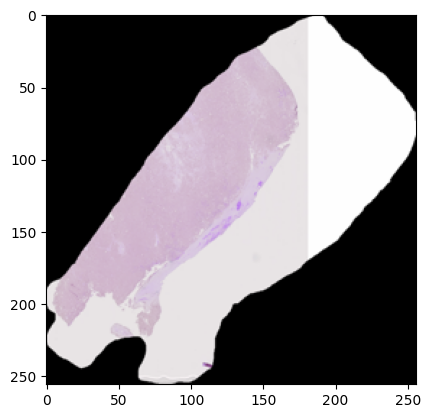

In [ ]:
x = Image.open(train_set[0][0])
plt.imshow(x.resize(IMAGE_INPUT_SIZE))
# plt.imshow(x.resize((1024, 1024)))
print(x.size, type(x))
x = transforms.Resize(IMAGE_INPUT_SIZE)(x)
print(x.size, type(x))
x = transforms.ToTensor()(x)
print(x.shape)
# x.save("test.jpg")


In [ ]:
from torchvision.io import read_image

class UBCDataset(Dataset):
    def __init__(self, img_path_and_label, transform=None, target_transform=None):
        self.data = img_path_and_label
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # image = read_image(img_path)
        image_path, label = self.data[idx]
        image = Image.open(image_path)
        # print(np.max(image), np.min(image))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        # print(torch.max(image), torch.min(image))
        return image, label


In [ ]:
# # put data into UBCDataset
# train_dataset = UBCDataset(train_set, transform=transforms.ToTensor())
# valid_dataset = UBCDataset(valid_set, transform=transforms.ToTensor())
# test_dataset = UBCDataset(test_set, transform=transforms.ToTensor())


In [ ]:
# put data into dataloader
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_INPUT_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = UBCDataset(train_set, transform=train_transform)
valid_dataset = UBCDataset(valid_set, transform=test_transform)
# test_dataset = UBCDataset(test_set, transform=test_transform)



In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0, 1, 3, 0, 4, 3, 0, 0])
torch.Size([8, 3, 256, 256])


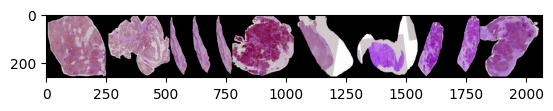

In [ ]:
for imgs, labels in train_dataloader:
    break
print(labels)
print(imgs.shape)
image_grid = torchvision.utils.make_grid(imgs, nrow=8)
plt.imshow(image_grid.permute(1, 2, 0).numpy())

In [ ]:
class UBC_CNN_MODEL(nn.Module):
    """
      Feel free to experiment on CNN model.
      You only need to report the model that has the best performance on the dataset.
    """

    def __init__(self, output_dim=5):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding="same")
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding="same")
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 16, 3, padding="same")
        self.bn3 = nn.BatchNorm2d(16)

        self.conv4 = nn.Conv2d(16, 32, 3, padding="same")
        self.bn4 = nn.BatchNorm2d(32)

        self.conv5 = nn.Conv2d(32, 16, 3, padding="same")
        self.bn5 = nn.BatchNorm2d(16)

        self.conv6 = nn.Conv2d(16, 16, 3, padding="same")
        self.bn6 = nn.BatchNorm2d(16)
        
        self.conv7 = nn.Conv2d(16, 16, 3, padding="same")
        self.bn7 = nn.BatchNorm2d(16)
        
        self.conv8 = nn.Conv2d(16, 16, 3, padding="same")
        self.bn8 = nn.BatchNorm2d(16)


        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(int(32/2)*16*16,64) 
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)

        self.first_pass = True

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.maxpool(x1)

        x2 = self.conv2(x1)
        x2 = self.bn2(x2)
        x2 = self.relu(x2)
        x2 = self.maxpool(x2)

        x2 = self.conv3(x2)
        x2 = self.bn3(x2)
        x2 = self.relu(x2)
        # x2 = self.maxpool(x2)
        
        # x2 = self.conv4(x2)
        # x2 = self.bn4(x2)
        # x2 = self.relu(x2)
        # x2 = self.maxpool(x2)
        
        # x2 = self.conv5(x2)
        # x2 = self.bn5(x2)
        # x2 = self.relu(x2)
        # x2 = self.maxpool(x2)
        
        # x2 = self.conv6(x2)
        # x2 = self.bn6(x2)
        # x2 = self.relu(x2)
        # x2 = self.maxpool(x2)

        # x2 = self.conv7(x2)
        # x2 = self.bn7(x2)
        # x2 = self.relu(x2)
        # x2 = self.maxpool(x2)

        # x2 = self.conv8(x2)
        # x2 = self.bn8(x2)
        # x2 = self.relu(x2)


        x3 = self.maxpool(x2)
        x4 = torch.flatten(x3, 1)
        # print(x4.shape)
        if(self.first_pass == True):
            self.fc1 = nn.Linear(x4.shape[1],64)
            if(x4.get_device() != -1):
                self.fc1 = self.fc1.to(x4.get_device())
        x4 = self.fc1(x4)
        x4 = self.relu(x4)
        x4 = self.fc2(x4)
        x4 = self.relu(x4)
        x4 = self.fc3(x4)

        self.first_pass = False
        
        return x4


In [ ]:
ubc_cnn_model = UBC_CNN_MODEL(output_dim=5).to(device)

In [ ]:
summary(ubc_cnn_model, (3, ) + IMAGE_INPUT_SIZE, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
         MaxPool2d-4         [-1, 16, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]           4,640
       BatchNorm2d-6         [-1, 32, 128, 128]              64
              ReLU-7         [-1, 32, 128, 128]               0
         MaxPool2d-8           [-1, 32, 64, 64]               0
            Conv2d-9           [-1, 16, 64, 64]           4,624
      BatchNorm2d-10           [-1, 16, 64, 64]              32
             ReLU-11           [-1, 16, 64, 64]               0
        MaxPool2d-12           [-1, 16, 32, 32]               0
             ReLU-13                   [-1, 64]               0
           Linear-14                   

In [ ]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(ubc_cnn_model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:
def eval(model, valid_dataloader, criteria, device):
        model.eval()
        valid_loss = 0.0
        valid_corrects = 0

        for imgs, labels in tqdm(valid_dataloader):
            imgs = imgs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(imgs)
                _, preds = torch.max(outputs, -1)
                loss = criteria(outputs, labels)

            valid_loss += loss.item() * imgs.size(0)
            valid_corrects += torch.sum(preds == labels.data).detach().cpu().numpy()

        valid_loss = valid_loss / len(valid_dataloader.dataset)
        valid_acc = valid_corrects / len(valid_dataloader.dataset)

        return valid_loss, valid_acc

In [ ]:
def train(model, train_dataloader, valid_dataloader, optimizer, criteria, num_epochs, eval_patience, device):
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []

    best_valid_loss = float('inf')
    best_valid_acc = -0.0001
    best_model_valid_loss = None
    best_model_valid_acc = None

    start_time = time.time()

    counter_eval_not_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        model.train()
        train_loss = 0.0
        train_corrects = 0

        for imgs, labels in tqdm(train_dataloader):
            imgs = imgs.to(device)
            labels = labels.to(device)


            outputs = model(imgs)
            _, preds = torch.max(outputs, -1)
            loss = criteria(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            train_corrects += torch.sum(preds == labels.data).detach().cpu().numpy()

        train_loss = train_loss / len(train_dataloader.dataset)
        train_acc = train_corrects / len(train_dataloader.dataset)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        print(f'Train loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        elapsed_time = time.time() - start_time
        print(f'Elapsed time: {time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}')

        valid_loss, valid_acc = eval(model, valid_dataloader, criteria, device)

        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_valid_loss = copy.deepcopy(model)
        
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_model_valid_acc = copy.deepcopy(model)
        else:
            counter_eval_not_improve += 1


        print(f'Valid loss: {valid_loss:.4f} Acc: {valid_acc:.4f}')
        elapsed_time = time.time() - start_time
        print(f'Elapsed time: {time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}')

        if counter_eval_not_improve >= eval_patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    return model, best_model_valid_acc, best_model_valid_loss, \
           train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [ ]:
def store_result(best_model_valid_acc, best_model_valid_loss, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list):
    create_dir_if_not_exist(MODEL_SAVE_DIR)
    create_dir_if_not_exist(RESULT_DIR)

    torch.save(best_model_valid_acc.state_dict(), Path(MODEL_SAVE_DIR) / "best_model_valid_acc.pth")
    torch.save(best_model_valid_loss.state_dict(), Path(MODEL_SAVE_DIR) / "best_model_valid_loss.pth")

    with open(Path(RESULT_DIR) / "train_loss_list.pkl", "wb") as f:
        pickle.dump(train_loss_list, f)
    with open(Path(RESULT_DIR) / "train_acc_list.pkl", "wb") as f:
        pickle.dump(train_acc_list, f)
    with open(Path(RESULT_DIR) / "valid_loss_list.pkl", "wb") as f:
        pickle.dump(valid_loss_list, f)
    with open(Path(RESULT_DIR) / "valid_acc_list.pkl", "wb") as f:
        pickle.dump(valid_acc_list, f)


In [ ]:
def plot_train_eval_result(train_loss_list, train_acc_list, valid_loss_list, valid_acc_list):
    epochs = np.arange(1, len(train_loss_list) + 1)

    plt.figure(figsize=(10, 4))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_loss_list, label='train')
    plt.plot(epochs, valid_loss_list, label='valid')
    plt.title('Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(2, 1, 2)
    plt.plot(epochs, [x*100 for x in train_acc_list], label='train')
    plt.plot(epochs, [x*100 for x in valid_acc_list], label='valid')
    plt.title('Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    
    plt.tight_layout()

In [ ]:
model_trained, best_model_valid_acc, best_model_valid_loss, \
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = \
train(ubc_cnn_model, train_dataloader, valid_dataloader, optimizer, criteria, num_epochs, eval_patience, device)



Epoch 1/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 1.6237 Acc: 0.0000


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.6399 Acc: 0.5000
Epoch 2/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 1.4252 Acc: 0.2500


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.5673 Acc: 0.5000
Epoch 3/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 1.2243 Acc: 0.5000


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.5517 Acc: 0.5000
Epoch 4/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 1.0840 Acc: 0.5000


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.5630 Acc: 0.0000
Epoch 5/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 1.1519 Acc: 0.3750


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.5496 Acc: 0.0000
Epoch 6/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# # train_loss_list = [data.cpu().item() for data in train_loss_list]
# train_acc_list = [data.cpu().item() for data in train_acc_list]
# # valid_loss_list = [data.cpu().item() for data in valid_loss_list]
# valid_acc_list = [data.cpu().item() for data in valid_acc_list]

In [ ]:
store_result(best_model_valid_acc, best_model_valid_loss, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)

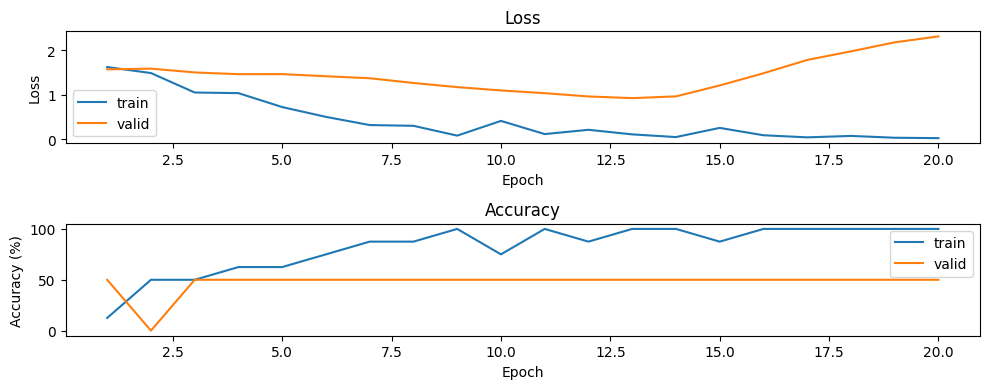

In [ ]:
plot_train_eval_result(train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)

In [ ]:
# efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
# utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

# efficientnet.eval().to(device)


In [ ]:
# # Download an example image
# import urllib
# url, filename = ("https://github.com/mateuszbuda/brain-segmentation-pytorch/raw/master/assets/TCGA_CS_4944.png", "TCGA_CS_4944.png")
# try: urllib.URLopener().retrieve(url, filename)
# except: urllib.request.urlretrieve(url, filename)


In [ ]:
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=1, init_features=32, pretrained=True)


In [ ]:
# import numpy as np
# from PIL import Image
# from torchvision import transforms

# input_image = Image.open(filename)
# m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
# preprocess = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=m, std=s),
# ])
# input_tensor = preprocess(input_image)
# input_batch = input_tensor.unsqueeze(0)

# if torch.cuda.is_available():
#     input_batch = input_batch.to('cuda')
#     model = model.to('cuda')

# with torch.no_grad():
#     output = model(input_batch)

# print(torch.round(output[0]))